# load libraries

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.integrate
from pylab import plt
import datetime
from scipy.optimize import curve_fit
import os
import itertools
from scipy.optimize import minimize
from datetime import datetime as time
from hyperopt import hp, tpe,rand, fmin

# the main class
1. make amount of params optional
2. add fitting into the function
3. epsabs should be manuable (used for intergration)
4. DONE - modify *.txt to .csv
5. DONE - readOut from csv files
6. compromise between P/S: fit separetly or together

In [2]:
from MSM import MSM_R
from FitMe import FitMe

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

/Users/dr.rub/Desktop/myScripts/MSM/MSM/MSM.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return b1/tau1*scipy.integrate.quad(self.core_t1_111(t,*a),0,t,epsabs=self.epsabs)[0]



100%|██████████| 40/40 [1:18:40<00:00, 118.02s/trial, best loss: 0.5639229389173807]


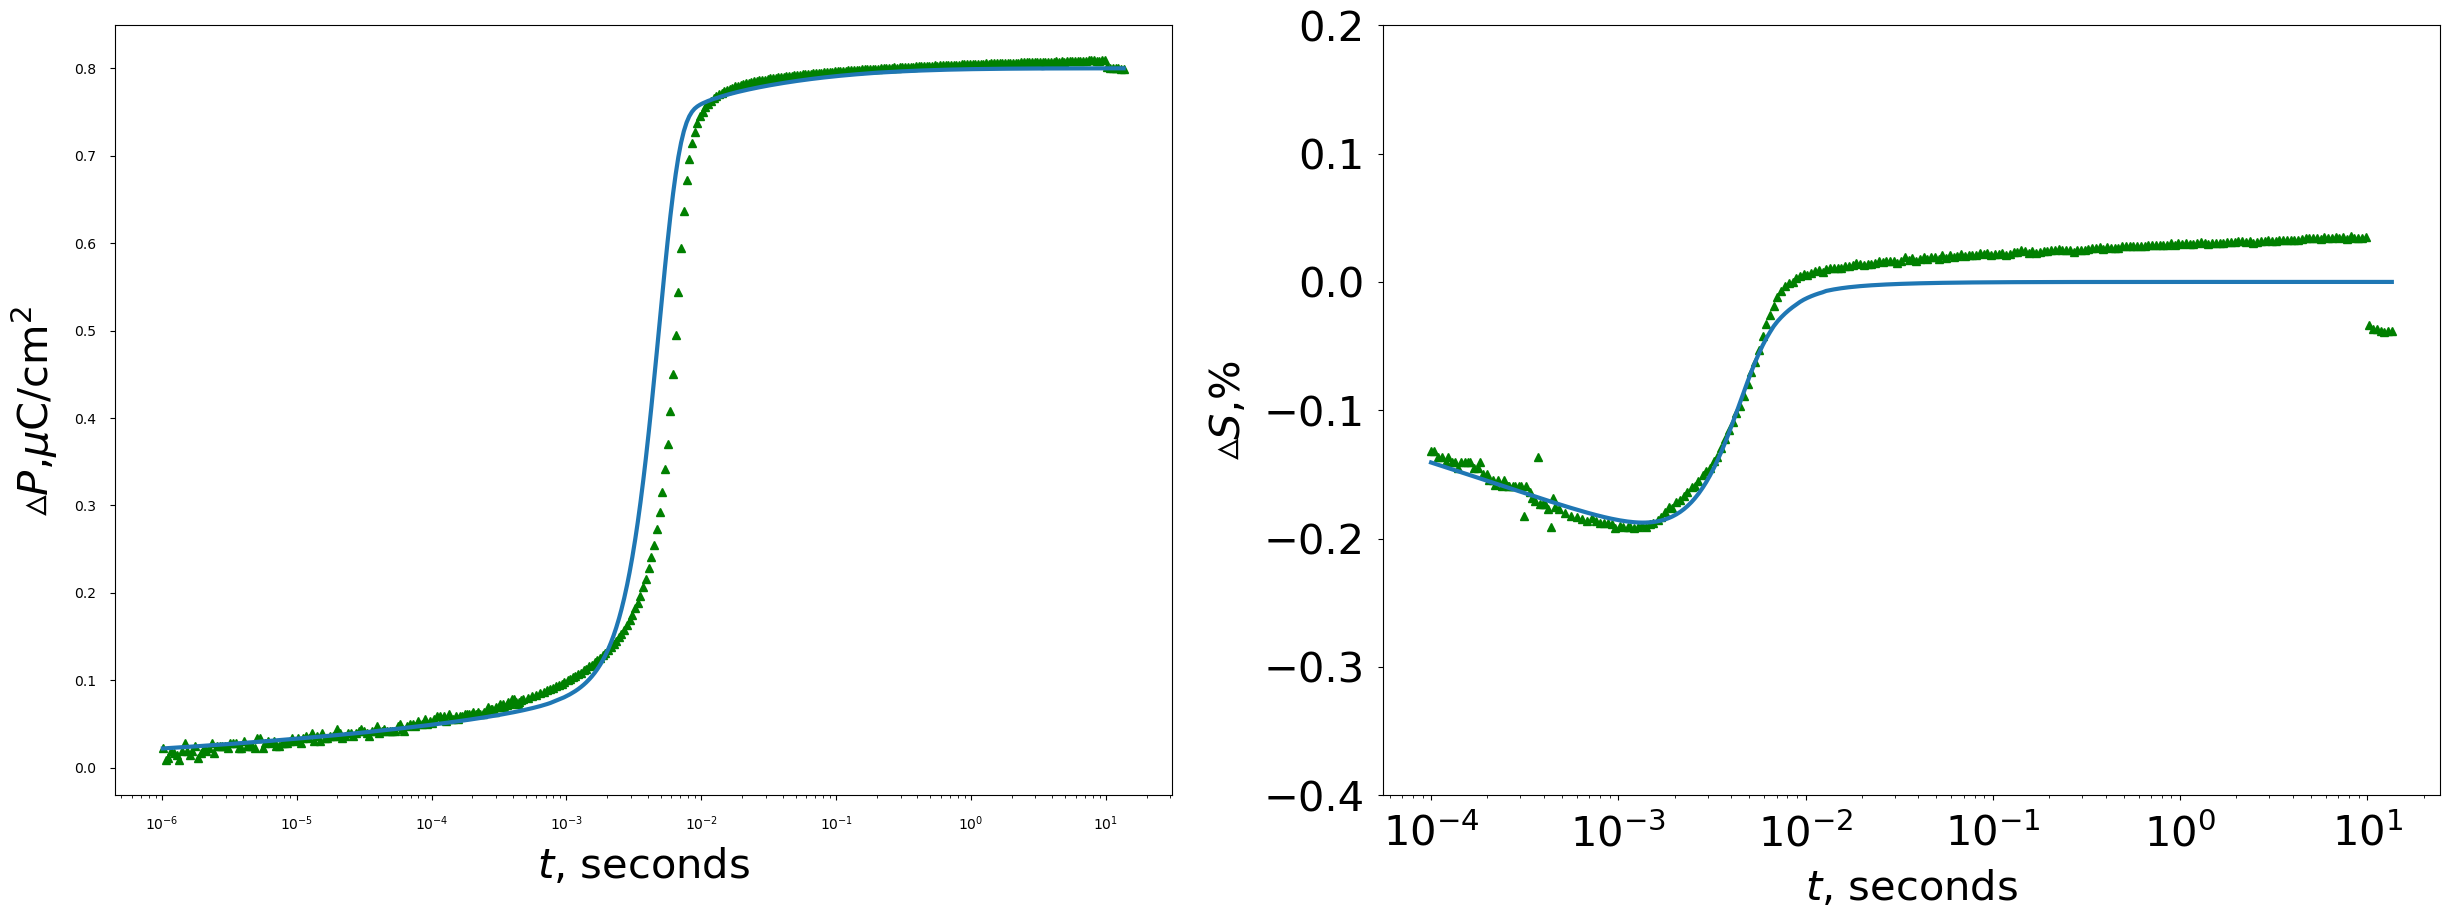

In [3]:
msmObj = MSM_R()
dP3=np.vectorize(msmObj.dP3)
dS3=np.vectorize(msmObj.dS3)

objFit = FitMe(dP3, dS3, pd.read_csv("pt_data.csv"), pd.read_csv("st_data.csv"))
best = objFit.fitMe()

Em=1100
data_part = 2
dataCSVP = pd.read_csv("pt_data.csv")[::data_part]
dataCSVS = pd.read_csv("st_data.csv")[::data_part]
time_p = dataCSVP["time"]
time_s = dataCSVS["time"]
polarization_data = dataCSVP[f"{Em}"]
strain_data = dataCSVS[f"{Em}"]

fig, (a1, a2) = plt.subplots(1, 2, figsize=(30, 10))
a1.plot(time_p,polarization_data/10**2,'g^')
a1.plot(time_p,dP3(Em, time_p,*best),linewidth=3.0)
a1.set_xscale('log')
a1.set_xlabel(r'$t$, seconds',fontsize=30)
a1.tick_params(axis='x', pad=10)
a1.set_ylabel(r'$ \vartriangle$$P$,$\mu$C/cm$^2$',fontsize=30)
a1.tick_params(axis='y', pad=10)
a1.xaxis.labelpad = 10
a1.yaxis.labelpad = 10
plt.ylim(-0.1,1.1)
plt.tick_params(labelsize=30)

a2.plot(time_s,strain_data,'g^')
a2.plot(time_s,dS3(Em, time_s,*best),linewidth=3.0)
a2.set_xscale('log')
a2.set_xlabel(r'$t$, seconds',fontsize=30)
a2.tick_params(axis='x', pad=10)  
a2.set_ylabel(r'$ \vartriangle$$S$,%',fontsize=30)
a2.tick_params(axis='y', pad=10)
a2.xaxis.labelpad = 10
a2.yaxis.labelpad = 10
plt.ylim(-0.4,0.2)
plt.tick_params(labelsize=30)
plt.show()

plt.show()

In [156]:
class MSM_R():

    def __init__(self,Em):
        self.Em=float(Em)
        self.tau0=0.7e-11 # should be optional?
        self.Ps=0.4*(1+0.021*(Em*1e-3-0.833)/0.4) # where the nubmbers come from?
        self.epsabs = 1e-3
        self.i = 0

    def tau(self,E):
        return self.tau0*np.exp(E*1e4/self.Em)

    def L20(self,t,*a):
        b2=a[10]
        b21=a[8]
        tau2=self.tau(a[4])
        tau21=self.tau(a[2])
        return b2/tau2*scipy.integrate.quad(lambda t1: (t1/tau2)**(b2-1)*np.exp(-(t1/tau2)**b2)*np.exp(-((t-t1)/tau21)**b21),0,t,epsabs=self.epsabs)[0]

    def L21(self,t,*a):
        b2=a[10]
        tau2=self.tau(a[4])
        return 1-np.exp(-(t/tau2)**b2)-self.L20(t,*a)

    def L101(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        b11=a[7]
        tau11=self.tau(a[1])
        return b1/tau1*scipy.integrate.quad(lambda t1: (t1/tau1)**(b1-1)*np.exp(-(t1/tau1)**b1)*np.exp(-((t-t1)/tau11)**b11),0,t,epsabs=self.epsabs)[0]

    def L102(self,t,*a):
        b1=a[6]
        b12=a[9]
        tau1=self.tau(a[0])
        tau12=self.tau(a[3])
        return b1/tau1*scipy.integrate.quad(lambda t1: (t1/tau1)**(b1-1)*np.exp(-(t1/tau1)**b1)*np.exp(-((t-t1)/tau12)**b12),0,t,epsabs=self.epsabs)[0]

    def L12(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return 1-np.exp(-(t/tau1)**b1)-self.L102(t,*a)

    def core_t2_110(self,t,t1,*a):
        b11=a[7]
        b111=a[8]
        tau11=self.tau(a[1])
        tau111=self.tau(a[2])
        return lambda t2: b11/tau11*((t2-t1)/tau11)**(b11-1)*np.exp(-((t2-t1)/tau11)**b11)*np.exp(-((t-t2)/tau111)**b111)

    def core_t1_110(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_110(t,t1,*a),t1,t,epsabs=self.epsabs)[0]

    def L110(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return b1/tau1*scipy.integrate.quad(self.core_t1_110(t,*a),0,t,epsabs=self.epsabs)[0]

    def core_t2_111(self,t,t1,*a):
        b11=a[7]
        b111=a[8]
        tau11=self.tau(a[1])
        tau111=self.tau(a[2])
        return lambda t2: b11/tau11*((t2-t1)/tau11)**(b11-1)*np.exp(-((t2-t1)/tau11)**b11)*(1-np.exp(-((t-t2)/tau111)**b111))

    def core_t1_111(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_111(t,t1,*a),t1,t,epsabs=self.epsabs)[0]

    def L111(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return b1/tau1*scipy.integrate.quad(self.core_t1_111(t,*a),0,t,epsabs=self.epsabs)[0]

    def dP3(self, Em, t, *a):
        self.i+=1
        eta11=np.sin(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta12=np.cos(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta2=np.cos(a[15])**2*np.sin(a[16])**2
        eta3=np.cos(a[16])**2
        tau_3=self.tau(a[5])
        Smax=a[12]
        d33=a[13]
        Em=self.Em
        Ps=self.Ps
        b3=a[11]
        tau3=self.tau(a[5])
        return 2*Ps*(eta3*(1-np.exp(-(t/tau3)**b3))+eta2*(2/3*self.L20(t,*a)+self.L21(t,*a))+eta12*(1/3*self.L102(t,*a)+self.L12(t,*a))+eta11*(1/3*self.L101(t,*a)+2/3*self.L110(t,*a)+self.L111(t,*a)))

    def dS3(self, Em, t, *a):
        Ps=self.Ps
        eta11=np.sin(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta12=np.cos(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta2=np.cos(a[15])**2*np.sin(a[16])**2
        eta3=np.cos(a[16])**2
        Smax=a[12]
        d33=0.37
        Em=self.Em
        return -Smax*(eta2*self.L20(t,*a)+eta12*self.L102(t,*a, Em)+eta11*(self.L101(t,*a)+self.L110(t,*a, Em)))#+d33*1e-7*Em*1e3*(self.dP3(t,*a)-Ps)+a[13]*1e-9*Em**2

    def tau_print(self,*a):
        eta11=np.sin(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta12=np.cos(a[14])**2*np.sin(a[15])**2*np.sin(a[16])**2
        eta2=np.cos(a[15])**2*np.sin(a[16])**2
        eta3=np.cos(a[16])**2
        print (eta11,eta12,eta2,eta3,eta11+eta12+eta2+eta3)

class FitMe():
    
    def __init__(self, dp3, ds3, data_P, data_S):
        data_part=2
        self.data_P = data_P[::data_part]
        self.data_S = data_S[::data_part]
        self.EmList = [1300]
        self.dp3 = dp3
        self.ds3 = ds3

    def error(self, args):
        time_p = self.data_P["time"]
        time_s = self.data_S["time"]
        comulativeError = 0
        for Em in self.EmList:
            p = self.data_P[f"{Em}"]
            s = self.data_S[f"{Em}"]
            comulativeError += np.mean(np.sqrt((p-self.dp3(Em, time_p, *args)*1e2)**2))/(max(p)-min(p))+\
                                np.mean(np.sqrt((s-self.ds3(time_s, *args, Em))**2))/(max(s)-min(s))
        return comulativeError

    def fitMe(self):
        s=np.array([1.94,2.025,2.2,2.22,2.14,2.22, 0.21,0.88,1.67,2.95,0.9,2.95, 0.79,1.63, 0.77,1.49,0.61])
        the_range=np.array([0.0001,0.0001,0.0001,0.0001, 0.0001,0.0001,  0.5,0.5,0.5,0.09, 0.5,0.09,  0.0001,0.0001, 0.5,0.5,0.5])
        s1=(1-0.2*the_range)*s
        s2=(1+0.2*the_range)*s
        space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
                 hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
                 hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                            hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                            hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a1',s1[14],s2[14]),hp.uniform('a2',s1[15],s2[15]),hp.uniform('a3',s1[16],s2[16])]
        return fmin(self.error,space,algo=tpe.suggest,max_evals=5)

In [157]:
Em = 1300

P=MSM_R(Em)
dP3=np.vectorize(P.dP3)
dS3=np.vectorize(P.dS3)
f = FitMe(dP3, dS3, pd.read_csv("pt_data.csv"), pd.read_csv("st_data.csv"))
f.error([1.5,2.025,2.2,2.22,2.14,2.22, 0.21,0.88,1.67,2.95,0.9,2.95, 0.79,1.63, 0.77,1.49,0.61])

/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_12089/1571479201.py:71: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_111(t,t1,*a),t1,t,epsabs=self.epsabs)[0]


0.3147366200131945

In [ ]:
# best = f.fitMe()

# b=best

# res_p=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a1"],b["a2"],b["a3"]]

# data_part=5
# dataCSV = pd.read_csv("pt_data.csv")[::data_part]
# time_p = dataCSV["time"]
# polarization_data = dataCSV[f"{Em}"]
# dataCSV = pd.read_csv("st_data.csv")[::data_part]
# time_s = dataCSV["time"]
# strain_data = dataCSV[f"{Em}"]

# fig, (a1, a2) = plt.subplots(1, 2, figsize=(30, 10))
# a1.plot(time_p,polarization_data/10**2,'g^')
# a1.plot(time_p,dP3(time_p,*res_p),linewidth=3.0)
# a1.set_xscale('log')
# a1.set_xlabel(r'$t$, seconds',fontsize=30)
# a1.tick_params(axis='x', pad=10)
# a1.set_ylabel(r'$ \vartriangle$$P$,$\mu$C/cm$^2$',fontsize=30)
# a1.tick_params(axis='y', pad=10)
# a1.xaxis.labelpad = 10
# a1.yaxis.labelpad = 10
# plt.ylim(-0.1,1.1)
# plt.tick_params(labelsize=30)

# plt.show()

 20%|██        | 1/5 [00:06<00:27,  6.85s/trial, best loss: 0.03778560289757407]

/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_1500/670950874.py:70: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_111(t,t1,*a),t1,t,epsabs=self.epsabs)[0]



100%|██████████| 5/5 [01:13<00:00, 14.67s/trial, best loss: 7.744624573607901]


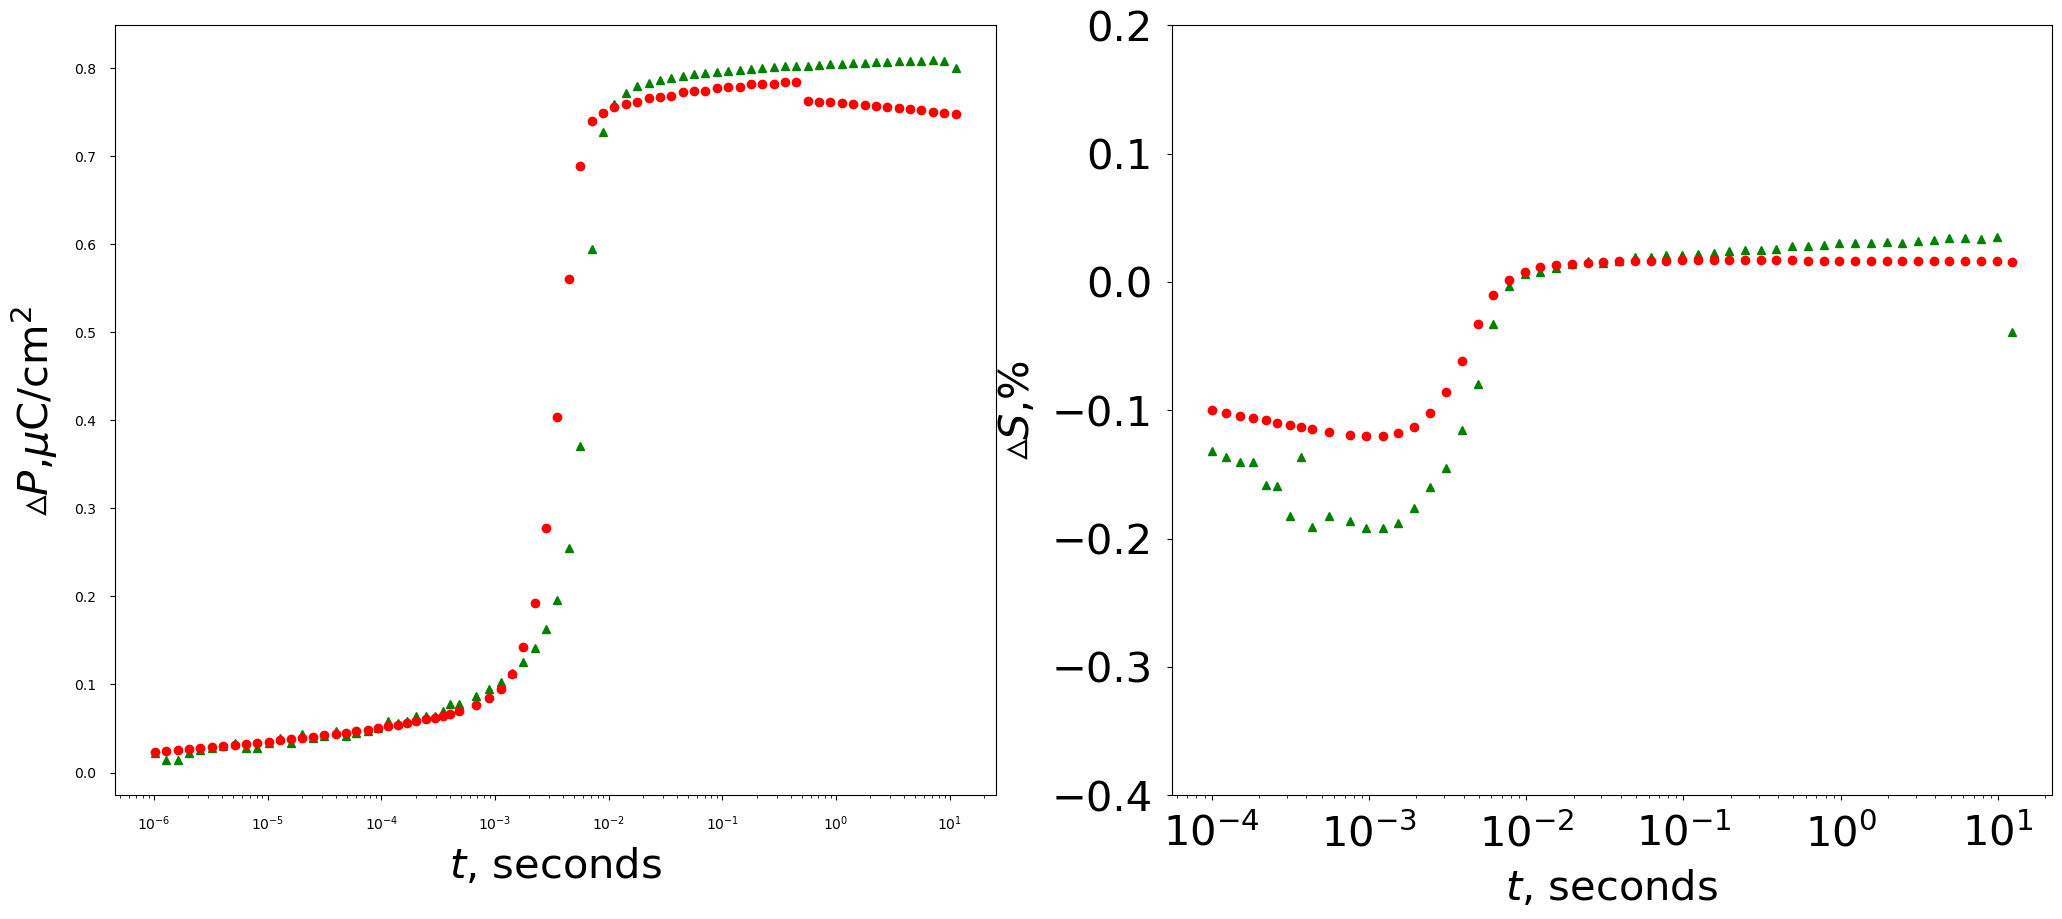

resulted parameters:
[1.9399520637381782,2.0249876560952256,2.199949438687364,2.2199762171258577,2.1399035835266895,2.2200111416830284, 0.1954549268219245,0.8187218066214939,1.4799792563364234,2.877722104874399,0.8323022539331548,2.9246905689014793, 0.7899607495475645,1.6300284156082705, 0.6554894055847555,1.3077219520578467,0.5642982285800673]

 eta11: 0.09908889549725144, eta12: 0.16760321886034452, eta2: 0.01934350138208496, eta3: 0.7139643842603192
Parameters:
E1: 1.9399520637381782, E11: 2.0249876560952256,E111: 2.199949438687364, E12: 2.2199762171258577, E2: 2.1399035835266895, E3: 2.2200111416830284, beta1: 0.1954549268219245, beta11: 0.8187218066214939, beta111: 1.4799792563364234, beta12: 2.877722104874399, beta2: 0.8323022539331548, beta3: 2.9246905689014793, deltaSmax: 0.7899607495475645, d33part: 1.6300284156082705, alpha1: 0.6554894055847555, alpha2: 1.3077219520578467, alpha3: 0.5642982285800673
0.03964806164879293
0.1152444298233651


In [46]:
#Read data and define error function
Em=1100

data_part=10

dataCSV = pd.read_csv("pt_data.csv")[::data_part]
time_p = dataCSV["time"]
polarization_data = dataCSV[f"{Em}"]
dataCSV = pd.read_csv("st_data.csv")[::data_part]
time_s = dataCSV["time"]
strain_data = dataCSV[f"{Em}"]

P=fit(Em)
p_vect=np.vectorize(P.dP3)
s_vect=np.vectorize(P.dS3)

def err_p(args):
    e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3=args
    p=[e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3]
    return np.mean(np.sqrt((polarization_data/1e2-p_vect(time_p,*p))**2))

def err_s(args):
    e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3=args
    p=[e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3]
    return np.mean(np.sqrt((strain_data-s_vect(time_s,*p))**2))

s=np.array([1.94,2.025,2.2,2.22,2.14,2.22, 0.21,0.88,1.67,2.95,0.9,2.95, 0.79,1.63, 0.77,1.49,0.61])
the_range=np.array([0.0001,0.0001,0.0001,0.0001, 0.0001,0.0001,  0.5,0.5,0.5,0.09, 0.5,0.09,  0.0001,0.0001, 0.5,0.5,0.5])
s1=(1-0.5*the_range)*s
s2=(1+0.2*the_range)*s

space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
         hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
         hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                    hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                    hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a1',s1[14],s2[14]),hp.uniform('a2',s1[15],s2[15]),hp.uniform('a3',s1[16],s2[16])]
best_p = fmin(err_p,space,algo=tpe.suggest,max_evals=5)

space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
         hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
         hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                    hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                    hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a1',s1[14],s2[14]),hp.uniform('a2',s1[15],s2[15]),hp.uniform('a3',s1[16],s2[16])]
best_s = fmin(err_s,space,algo=tpe.suggest,max_evals=5)

num_of_sets=1


# to find an optimal set between P and S params?    
for i in range(num_of_sets):    
    
    #search for optimal parameeter set
    b=best_p
    res_p=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a1"],b["a2"],b["a3"]]
    b=best_s
    res_s=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a1"],b["a2"],b["a3"]]

    def f(args):
        e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3=args
        share_p=np.array([e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a1,a2,a3])
        share_s=1-share_p
        res=np.array(res_p)*share_p+np.array(res_s)*share_s
        p=np.mean(np.sqrt((polarization_data/10**2-p_vect(time_p,*res))**2))/minmax_p*100
        s=np.mean(np.sqrt((strain_data-s_vect(time_s,*res))**2))/minmax_s*100
        return 0.5*(p+s)

    s=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5])
    s1=s-2*np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.2,0.2,0.2,0.2,0.2,0.2, 0.0001,0.0001, 0.2,0.2,0.2])
    s2=s+2*np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.2,0.2,0.2,0.2,0.2,0.2, 0.0001,0.0001, 0.2,0.2,0.2])

    space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
             hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
             hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                        hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                        hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a1',s1[14],s2[14]),hp.uniform('a2',s1[15],s2[15]),hp.uniform('a3',s1[15],s2[15])]
    best = fmin(f, space, algo=tpe.suggest, max_evals=5)
    b=best
    sh=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a1"],b["a2"],b["a3"]]
    res=np.array(res_p)*np.array(sh)+np.array(res_s)*(1-np.array(sh))

    fig, (a1, a2) = plt.subplots(1, 2, figsize=(25, 10))
    a1.plot(time_p,polarization_data/10**2,'g^')
    a1.plot(time_p,p_vect(time_p,*res),"ro")
    a1.set_xscale('log')
    a1.set_xlabel(r'$t$, seconds',fontsize=30)
    a1.tick_params(axis='x', pad=10)
    a1.set_ylabel(r'$ \vartriangle$$P$,$\mu$C/cm$^2$',fontsize=30)
    a1.tick_params(axis='y', pad=10)
    a1.xaxis.labelpad = 10
    a1.yaxis.labelpad = 10
    plt.ylim(-0.1,1.1)
    plt.tick_params(labelsize=30)

    a2.plot(time_s,strain_data,'g^')
    a2.plot(time_s,s_vect(time_s,*res),"ro")
    a2.set_xscale('log')
    a2.set_xlabel(r'$t$, seconds',fontsize=30)
    a2.tick_params(axis='x', pad=10)
    a2.set_ylabel(r'$ \vartriangle$$S$,%',fontsize=30)
    a2.tick_params(axis='y', pad=10)
    a2.xaxis.labelpad = 10
    a2.yaxis.labelpad = 10
    plt.ylim(-0.4,0.2)
    plt.tick_params(labelsize=30)
    plt.show()

    print ('resulted parameters:\n[{},{},{},{},{},{}, {},{},{},{},{},{}, {},{}, {},{},{}]'.format(res[0],res[1],
                                   res[2],res[3],
                                   res[4],res[5],res[6],
                                   res[7],
                                   res[8],res[9],
                                   res[10],
                                   res[11],res[12],res[13],
                                   res[14],
                                   res[15],res[16]))
    print ('\n eta11: {}, eta12: {}, eta2: {}, eta3: {}'.format(np.sin(res[14])**2*np.sin(res[15])**2*np.sin(res[16])**2, np.cos(res[14])**2*np.sin(res[15])**2*np.sin(res[16])**2, 
                                                           np.cos(res[15])**2*np.sin(res[16])**2, np.cos(res[16])**2))

    print ('Parameters:\nE1: {}, E11: {},E111: {}, E12: {}, E2: {}, E3: {}, beta1: {}, beta11: {}, beta111: {}, beta12: {}, beta2: {}, beta3: {}, deltaSmax: {}, d33part: {}, alpha1: {}, alpha2: {}, alpha3: {}'.format(res[0],res[1],
                                   res[2],res[3],
                                   res[4],res[5],res[6],
                                   res[7],
                                   res[8],res[9],
                                   res[10],
                                   res[11],res[12],res[13],
                                   res[14],
                                   res[15],res[16]))

    print (err_p(res)/minmax_p)
    print (err_s(res)/minmax_s)


    with open("Parameters1100.csv", 'a') as f:
            f.write('E1: {}, E11: {},E111: {}, E12: {}, E2: {}, E3: {}, beta1: {}, beta11: {}, beta111: {}, beta12: {}, beta2: {}, beta3: {}, deltaSmax: {}, d33part: {}, alpha1: {}, alpha2: {}, alpha3: {}, eta11: {}, eta12: {}, eta2: {}, eta3: {}, err_p: {}, err_s: {}\n'.format(res[0],res[1],
                                   res[2],res[3],
                                   res[4],res[5],res[6],
                                   res[7],
                                   res[8],res[9],
                                   res[10],
                                   res[11],res[12],res[13],
                                   res[14],
                                   res[15],res[16],np.sin(res[14])**2*np.sin(res[15])**2*np.sin(res[16])**2, np.cos(res[14])**2*np.sin(res[15])**2*np.sin(res[16])**2, 
                                                               np.cos(res[15])**2*np.sin(res[16])**2, np.cos(res[16])**2,err_p(res),err_s(res)))
            f.close()


0.14729043954576032 0.1695346790708854 8.779337738803757e-05 0.6830870880059663 1.0


/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_1500/670950874.py:70: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_111(t,t1,*a),t1,t,epsabs=self.epsabs)[0]


0.04731111524389801
0.09580075366601393


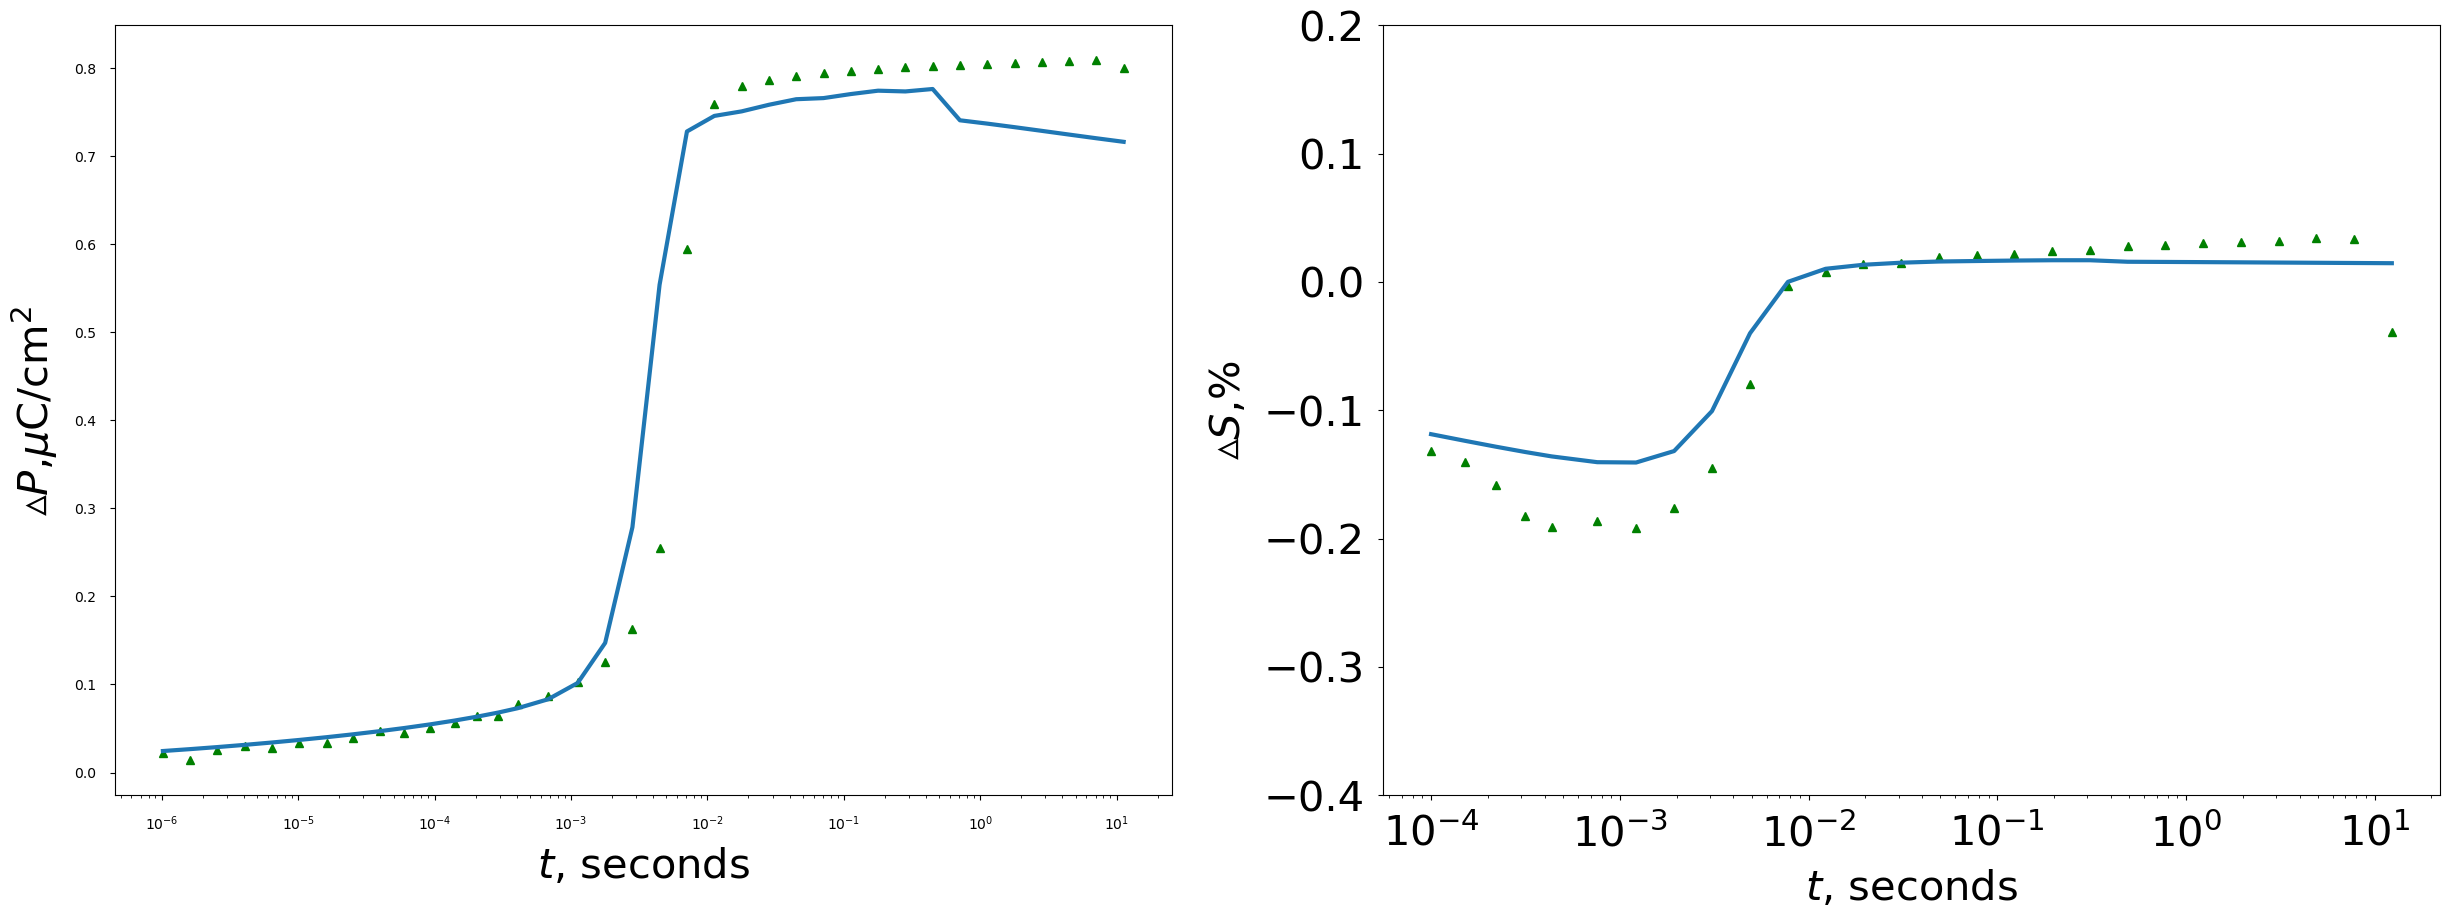

Parameters:
E1: 1.9409716753994353, E11: 2.025428886976342,E111: 2.202832697245471, E12: 2.22, E2: 2.13784622483786, E3: 2.22, beta1: 0.21166387633730077, beta11: 0.7986027080318459, beta111: 1.6941493931406284, beta12: 2.853434880784456, beta2: 0.6894768972230904, beta3: 2.9357377731842424, deltaSmax: 0.795483538087242, d33part: 1.634519264247625, alpha1: 0.7502643402268919, alpha2: 1.5874412181652828, alpha3: 0.5979510114483642

 eta11: 0.14729043954576032, eta12: 0.1695346790708854, eta2: 8.779337738803757e-05, eta3: 0.6830870880059663


In [47]:
#for hand tuning
Em=1100

data_part=20

dataCSV = pd.read_csv("pt_data.csv")[::data_part]
time_p = dataCSV["time"]
polarization_data = dataCSV[f"{Em}"]
dataCSV = pd.read_csv("st_data.csv")[::data_part]
time_s = dataCSV["time"]
strain_data = dataCSV[f"{Em}"]

reihe=[1.9409716753994353,2.025428886976342,2.202832697245471,2.22,2.13784622483786,2.22, 0.21166387633730077,0.7986027080318459,1.6941493931406284,2.853434880784456,0.6894768972230904,2.9357377731842424, 0.795483538087242,1.634519264247625, 0.7502643402268919,1.5874412181652828,0.5979510114483642]
P=fit(Em)
P.tau_print(*reihe)
p_vect=np.vectorize(P.dP3)
s_vect=np.vectorize(P.dS3)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(30, 10))
a1.plot(time_p,polarization_data/10**2,'g^')
a1.plot(time_p,p_vect(time_p,*reihe),linewidth=3.0)
a1.set_xscale('log')
a1.set_xlabel(r'$t$, seconds',fontsize=30)
a1.tick_params(axis='x', pad=10)
a1.set_ylabel(r'$ \vartriangle$$P$,$\mu$C/cm$^2$',fontsize=30)
a1.tick_params(axis='y', pad=10)
a1.xaxis.labelpad = 10
a1.yaxis.labelpad = 10
plt.ylim(-0.1,1.1)
plt.tick_params(labelsize=30)

a2.plot(time_s,strain_data,'g^')
a2.plot(time_s,s_vect(time_s,*reihe),linewidth=3.0)
a2.set_xscale('log')
a2.set_xlabel(r'$t$, seconds',fontsize=30)
a2.tick_params(axis='x', pad=10)  
a2.set_ylabel(r'$ \vartriangle$$S$,%',fontsize=30)
a2.tick_params(axis='y', pad=10)
a2.xaxis.labelpad = 10
a2.yaxis.labelpad = 10
plt.ylim(-0.4,0.2)
plt.tick_params(labelsize=30)
plt.show()

print ('Parameters:\nE1: {}, E11: {},E111: {}, E12: {}, E2: {}, E3: {}, beta1: {}, beta11: {}, beta111: {}, beta12: {}, beta2: {}, beta3: {}, deltaSmax: {}, d33part: {}, alpha1: {}, alpha2: {}, alpha3: {}'.format(reihe[0],reihe[1],
                               reihe[2],reihe[3],
                               reihe[4],reihe[5],reihe[6],
                               reihe[7],
                               reihe[8],reihe[9],
                               reihe[10],
                               reihe[11],reihe[12],reihe[13],
                               reihe[14],
                               reihe[15],reihe[16]))
print ('\n eta11: {}, eta12: {}, eta2: {}, eta3: {}'.format(np.sin(reihe[14])**2*np.sin(reihe[15])**2*np.sin(reihe[16])**2, np.cos(reihe[14])**2*np.sin(reihe[15])**2*np.sin(reihe[16])**2, 
                                                           np.cos(reihe[15])**2*np.sin(reihe[16])**2, np.cos(reihe[16])**2))